In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

### 2 Sample t-test (p.139)

- 1 sample t-test이 단일 집단에 대한 모평균을 검정하는 것과 다르게, 2 sample t-test는 **두 집단에 대한 평균 차이를 검정**한다.
    - 두 확률표본이 두 모집단으로부터 독립적으로 관측되었을 경우 "독립 2표본 검정"을 사용한다.

#### 절차
1. 정규성 검정
2. 등분산성 검정
    - 정규분포를 따르는 경우: F test
    - 정규분포를 따르지 않는 경우: Levene's test
3. 평균 검정
    - 두 집단이 등분산인 경우: Student's t test
    - 두 집단의 분산이 다른 경우: Welch's t test
4. 설정된 가설 검정
    - $H_0$: 두 집단의 평균은 동일
    - $H_1$: 두 집단의 평균은 다름

#### 2 sample t test의 검정 통계량
$$ t = \dfrac {(\bar x_1 - \bar x_2) - (\mu_1 - \mu_2)}{\sqrt {\dfrac{s^2_1}{n_1} + \dfrac{s^2_2}{n_2}}} $$<br>
- $\bar x$: 표본평균
- $n$: 표본 크기
- $\mu$: 미지(unknown)의 모평균 => *이걸 찾고 싶음*
- $s$: 표본표준편차
> 위의 검정통계량 수식을 바탕으로 유의성 검정을 하는데, 모표준편차를 알고 있는 경우 $s$를 $\sigma$로 바꾸고 Z 통계량을 사용한다. 모표준편차를 모르는 경우 위와 같이 표본표준편차 $s$를 사용하고 t 통계량을 사용한다.

#### 모평균($\mu$)의 신뢰구간
$$ (\bar x_1 - \bar x_2) \pm t^* \sqrt {\dfrac{s^2_1}{n_1} + \dfrac{s^2_2}{n_2}} $$
- 위에서 t는 자유도 $n_1 + n_2 -2$의 t 통계량이다.
    - $t^* = t(n_1+n_2 -2,\;\alpha/2)$

In [123]:
# 데이터 입력하기
df1 = pd.DataFrame({'sample_A': [1.883, 1.715, 1.799, 1.768,
                          1.711, 1.832, 1.427, 1.344]})
df2 = pd.DataFrame({'sample_B': [1.435, 1.572, 1.486, 1.511,
                          1.457, 1.548, 1.404, 1.883]})
df = pd.concat([df1, df2], axis=1)
df.head()

,sample_A,sample_B
0,1.883,1.435
1,1.715,1.572
2,1.799,1.486
3,1.768,1.511
4,1.711,1.457


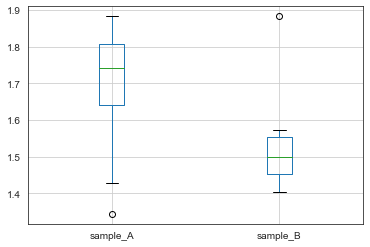

In [62]:
# boxplot으로 데이터 시각화
df.boxplot()
plt.show()

- sample_A와 sample_B 모두에 outlier가 있다.
- sample_A는 sample_B에 비해서 IQR이 약 3배 크고, left skewed되어 있다.
- B는 작은 Range의 정규분포를 띄는 것으로 보이나; IQR의 4배 정도 되어 보이는 Outlier를 가지고 있다.

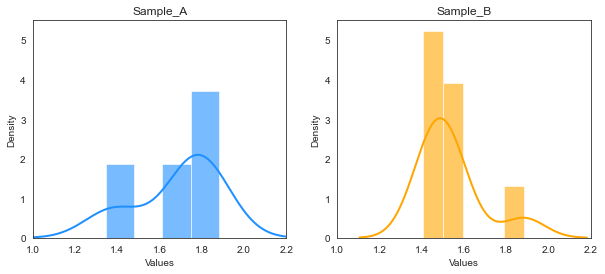

In [63]:
# histogram and density curve로 데이터 시각화
fig,ax = plt.subplots(1, 2, figsize=(10,4))
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

sns.distplot(df1, color="dodgerblue", label="Compact", **kwargs,
             ax=ax[0])
ax[0].set_xlabel('Values')
ax[0].set_title('Sample_A')
ax[0].set_ylim([0, 5.5])
ax[0].set_xlim([1, 2.2])
sns.distplot(df2, color="orange", label="SUV", **kwargs,
             ax=ax[1])
ax[1].set_xlabel('Values')
ax[1].set_title('Sample_B')
ax[1].set_ylim([0, 5.5])
ax[1].set_xlim([1, 2.2])

plt.show()

- histogram & density plot으로 비교해보니 sample_A는 left-skewed; sample_B는 다소 right-skewed 형태다.
- sample_B의 경우 1.4\~1.6의 값을 갖는 관측치가 거의 8~90%에 달한다.

In [65]:
# 정규성 검정
df1_stat, df1_pval = stats.shapiro(df1)
df2_stat, df2_pval = stats.shapiro(df2)

print("Sample A의 정규성 검정 결과:")
print("Statistic: {0:.3f}, P-Value: {1:.3f}\n".format(df1_stat,
                                                    df1_pval))
print("Sample B의 정규성 검정 결과:")
print("Statistic: {0:.3f}, P-Value: {1:.3f}".format(df2_stat,
                                                    df2_pval))

Sample A의 정규성 검정 결과:
Statistic: 0.843, P-Value: 0.080

Sample B의 정규성 검정 결과:
Statistic: 0.773, P-Value: 0.015


- shapiro 정규성 검정 결과, Sample A는 p-value가 0.08로 유의수준인 0.05보다 크므로 귀무가설을 채택한다 => 정규분포를 따른다.
    - 하지만 **Sample B는 p-value가 0.015로** 유의수준인 0.05보다 낮으므로 **귀무가설을 기각한다** => 정규분포를 따르지 않는다.
> 따라서 정규분포를 따르지 않을 때 이용하는 등분산성 검정 기법인 Levene's Test를 시행한다.

In [68]:
# 등분산성 검정
lev_stat, lev_pval = stats.levene(df1.values.ravel(),
                                  df2.values.ravel())
print("Sample A와 Sample B의 등분산성 검정 결과(Levene):")
print("Statistic: {0:.3f}, P-Value: {1:.3f}\n".format(lev_stat,
                                                      lev_pval))

Sample A와 Sample B의 등분산성 검정 결과(Levene):
Statistic: 0.441, P-Value: 0.518



- 등분산성 검정 결과 p-value가 0.51로 유의수준인 0.05보다 높으므로 귀무가설을 채택한다 => 두 그룹은 등분산성을 갖고 있다.
- 등분산성이 같기 때문에 Student's t test로 두 집단 간 평균 차이를 검정한다.

In [92]:
# 평균 차이 검정
t_result = stats.ttest_ind(df1, df2, equal_var=True)

t_stat, t_pval = t_result.statistic.round(3),\
                 t_result.pvalue.round(3)
print("Sample A와 Sample B의 평균 차이 검정 결과(Student's):")
print("Statistic:", t_stat, " P-Value:",t_pval)

Sample A와 Sample B의 평균 차이 검정 결과(Student's):
Statistic: [1.7]  P-Value: [0.111]


- 두 집단의 평균의 차이를 비교했을 때, t 통계량은 1.7이고; p-value는 0.111이다.
    - p-value가 유의수준인 0.05보다 높으므로, 귀무가설을 채택한다 => **두 집단의 평균의 차이는 통계적으로 유의하지 않다.**
    - (두 집단이 보이는 평균의 차이는 '우연히 발생할 수 있는 수준'의 차이다.

### Paired t-test (p.142)
- **같은 단위**, 즉 **같은 feature를 갖는 2개 데이터의 차이(difference)** 가 유의한지를 검정한다.
    - 2개 샘플의 **차이(difference)를 하나의 칼럼** 으로 만들고, 그 칼럼을 검정함으로써 2개 샘플 사이에 유의미한 차이가 있는지 알아낸다.
> - difference 칼럼에 대한 *정규성 검정은 필요하지만*,
> - 칼럼이 하나이기 때문에 *등분산성 검정은 할 필요 없다*.

In [101]:
df = pd.read_csv('data/data2/paired.csv')
df.head()

,before,after
0,720,810
1,589,670
2,780,790
3,648,712
4,720,810


<AxesSubplot:>

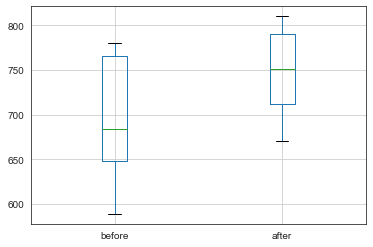

In [102]:
# 먼저 boxplot으로 시각화해본다.
df.boxplot()

- before에 비해 after의 IQR이 크게 줄어든 것이 눈에 띈다.
- 한 눈에 보기에는 after와 before의 차이가 유의미해 보인다.

In [112]:
# paired t test 시행
t_result = stats.ttest_rel(df['after'], df['before'])

t_stat, t_pval = t_result.statistic.round(3),\
                 t_result.pvalue.round(3)

print("Before과 After의 평균 차이 검정 결과(Student's):")
print("Statistic:", t_stat, " P-Value:",t_pval)

Before과 After의 평균 차이 검정 결과(Student's):
Statistic: 5.324  P-Value: 0.0


- 검정 결과 p-value는 0.0으로 유의수준인 0.05보다 낮다 => 귀무가설을 기각한다 => **before과 after의 데이터에는 통계적으로 유의미한 차이가 있다.**

### 1 Proportion test (p.148)
- 한 집단의 비율이 특정 비율과 같은지를 검정한다.
- 1 proportion test가 다루는 문제는 예를 들어 다음과 같다: "공정의 불량률이 10%인가?"
    - 이 때 귀무가설은 $H_0: p = 0.1$ 일 것이고,
    - 대립가설은 $H_1: p \neq 0.1$일 것이다.

> 동전이 정상적인가 검정하기 위해 100번 던져본 결과, 앞면이 40번 뒷면이 60번 나왔다. 이 동전은 정상인가? (유의수준 0.05)
    > - 여기서 $H_0: p = 0.5$ // $H_1: p \neq 0.5$ 이다.

In [119]:
value = 0.5   # 귀무가설 기준 기대하는 비율
n_obs = 100      # 100번 동전을 던졌다
count = 40      # 앞면이 40번 나왔다

In [120]:
# proportion test 시행
stat, pval = proportions_ztest(count, n_obs, value)
print("1 Proportion Test 결과:")
print("Statistic: {0:.3f}, P-Value: {1:.3f}\n".format(stat,
                                                      pval))

1 Proportion Test 결과:
Statistic: -2.041, P-Value: 0.041



- 검정 결과 p-value가 0.041로 유의수준인 0.05보다 낮게 나왔다 => 귀무가설을 기각한다 => **"이 동전은 비정상이다"라는 주장이 통계적으로 유의하다!**


In [121]:
count = 41   # 앞면이 나온 횟수를 41로 고쳐보면,
stat, pval = proportions_ztest(count, n_obs, value)
print("1 Proportion Test 결과:")
print("Statistic: {0:.3f}, P-Value: {1:.3f}\n".format(stat,
                                                      pval))

1 Proportion Test 결과:
Statistic: -1.830, P-Value: 0.067



- 앞면이 나온 횟수를 41로 바꿔보니, p-value가 0.067이므로 귀무가설이 채택된다.
- 앞면이 1번만 더 나왔더라면 동전은 정상이었을텐데..

### 2 Proportion test (p.151)
- 2 Proportion test는 **"두 집단의 비율이 같은지를 검정한다."**
    
> 동일한 제품을 생산하는 두 공장에서 불량률을 측정한 결과가 아래와 같을 때, 두 공정의 불량률이 같은가?
    > - 귀무가설은 $H_0: p_1 = p_2$
    > - 대립가설은 $H_1: p_1 \neq p_2$

In [122]:
# 공장 A, B에서 불량품이 각각 14개, 5개 나왔다.
count = np.array([14, 5])
# 공장 A, B에서 생산한 제품 수는 각각 1200개다.
nobs = np.array([1200, 1200])

# 2 proportion test 시행
stat, pval = proportions_ztest(count, nobs)

print("2 Proportion Test 결과:")
print("Statistic: {0:.3f}, P-Value: {1:.3f}\n".format(stat,
                                                      pval))

2 Proportion Test 결과:
Statistic: 2.073, P-Value: 0.038



- 두 집단의 불량률을 2 proportion test 해본 결과 p-value는 0.038로 유의수준 0.05보다 낮다. => 귀무가설을 기각한다 => **두 공장의 불량률에는 통계적으로 유의미한 차이가 있다.**

### 카이제곱 검정 (p.159)
- **관찰된 빈도가 기대되는 빈도와 의미 있게 다른지** 의 여부를 검증하는 방법
    - 자료가 빈도로 주어진 상황에서, **특히 범주형 자료의 분석** 에 이용된다.

> - **동일성 검정**: 특성 별 두 가지 이상으로 분류된 범주간에 상호 동일한 비율로 나타나는가를 검정하고자 할 때 사용함
    - "A 공장에서 작업하는 3개의 강종에 대하여 4개 조별 작업분에 대하여 각 강종별 조별로 불량률 차이가 있는가?"
> - **독립성 검정**: 특성 별 두 가지 이상으로 분류된 범주간에 상호 관련성이 있는지를 검정하고자 할 때 사용함
    - "현대/GM/기아 자동차 소유주와 강남/강북 거주자 사이의 관계가 있는가? (브랜드와 거주지 사이에 관계가 있는가?)"
> - **적합도 검정**: 어떤 특성치 또는 사건이 기대치에 따라 발생했는지 여부를 검정하고자 할 때 사용함
    - "완두콩 수확을 해보니 외관이 4가지 종류이고 수확량이 170, 60, 80, 30이라면 멘델의 유전법칙(9:3:3:1)과 일치한다고 할 수 있나?
    - 이 표본데이터가 와이블분포를 따르나? 지수분포를 따르나?? 이런 게 궁금할 때!

#### 카이제곱 검정통계량
$$ \chi^2 = \sum \dfrac {(f_o - f_e)^2}{f_e} $$
$$ f_o:\;\text 실측치 $$
$$ f_e:\;\text 기대치 $$

> **카이제곱 검정통계량이 크다는 것은 실측치 대비 기대치의 차이가 크다는 것이다 => 귀무가설을 기각한다.**

#### 아래 실습 예제
- 노트북 컴퓨터 6가지 제품에 대해 7가지 제품의 이미지를 중복선택할 수 있도록 32명의 소비자를 대상으로 설문조사를 했다. 각 제품에 대한 이미에 유의미한 차이가 있는가?
    - 귀무가설은 $H_0: \text{제품별 이미지 인식에 차이가 없다}$
    - 대립가설은 $H_1: \text{차이가 있다}$

In [132]:
df = pd.read_csv('data/data2/카이제곱_노트북.csv')
df.index = ['A/S', '가격', '성능', '확장성', '디자인', '안정성', '기능성']
df.head()

,A,B,C,D,E,F
A/S,18,8,4,4,3,3
가격,2,2,1,1,1,25
성능,14,14,3,2,3,8
확장성,5,5,4,3,1,10
디자인,5,5,9,2,1,2


In [133]:
# 카이제곱검정 시행
chi, pval, dof, expected = stats.chi2_contingency(df)

print("카이제곱검정 시행 결과:")
print("Chi2 Statistic: {0:.3f}, P-Value: {1:.3f}".format(chi,
                                                         pval))

카이제곱검정 시행 결과:
Chi2 Statistic: 95.759, P-Value: 0.000


- 카이제곱검정 시행 결과, p-value는 0.000으로 유의수준인 0.05보다 낮다 => 귀무가설을 기각한다 => **소비자의 제품별 이미지 인식에는 통계적으로 유의미한 차이가 있다.**
- 아쉬운 점은 카이제곱검정이 말해줄 수 있는 게 "집단 간 차이가 있다"라는 것밖에 없다는 점이다.
    - 어떤 집단과 어떤 집단의 차이가 가장 극명한지,
    - 총 몇 가지의 차이가 존재하는지 등에 대해서 알고 싶다면 후속 기법을 써야 한다.

### One Way ANOVA (p.167)
- ANOVA는 비교 대상이 되는 집단들 간의 평균의 차이를 검정하는 것이다.
    - ANOVA도 카이제곱검정의 한계점처럼 '차이가 적어도 하나 이상 존재한다'는 것만 말해줄 수 있다.

#### 실습 예제
- 강종별과 type에 따라 2차 정련 시간에 차이가 있는가?

In [139]:
df = pd.read_csv('data/ANOVA.csv')
df.head()

,time,charge,gangjong,type
0,32.2,A,a,a
1,30.4,B,a,a
2,33.6,C,a,a
3,36.4,D,a,a
4,33.9,E,a,a


<AxesSubplot:title={'center':'time'}, xlabel='gangjong'>

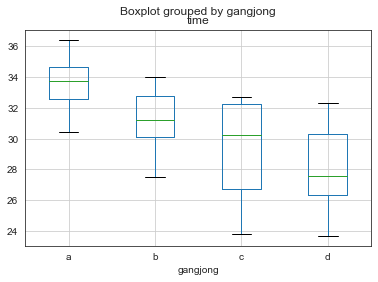

In [136]:
# box plot by gangjong
df.boxplot("time", by="gangjong")

In [145]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

lm = ols("time ~ C(gangjong)", data=df).fit()

print(anova_lm(lm))

               df      sum_sq    mean_sq         F    PR(>F)
C(gangjong)   3.0  104.603333  34.867778  4.171868  0.019013
Residual     20.0  167.156667   8.357833       NaN       NaN


> 이 부분은 아직 잘 이해가 되지 않아서, 더 공부해보고 insight를 찾겠습니다.

### 상관분석 (p.174)
- 두 연속형 변수 사이의 선형적 관계의 강도와 방향을 분석한다.

$$ \rho = \dfrac{Cov(X,\;Y)}{\sqrt{Var(X)\;Var(Y)}}$$

$$ \begin{align}
\hat \rho = r = \dfrac{S_{(xy)}}{\sqrt{S_{(xx)} S_{(yy)}}} & = \dfrac{\dfrac{1}{N} \sum (x_i - \bar x)(y_i - \hat y)}{\sqrt{\dfrac{1}{N} \sum (x_i - \bar x)^2 \cdot \dfrac{1}{N} \sum(y_i - \bar y)^2}} \\
    & = \dfrac{\sum (x_i - \bar x)(y_i - \hat y)}{\sqrt{\sum (x_i - \bar x)^2 \cdot \sum(y_i - \bar y)^2}} \\
\end{align}
$$

In [148]:
df = pd.DataFrame({'Strength': [37.6, 38.6, 37.2, 36.4, 38.6,
                                39.0, 37.2, 36.1, 35.9, 37.1,
                                36.9, 37.5, 36.3, 38.1, 39.0,
                                36.9, 36.8, 37.6, 33.0, 33.5],
                   'Temperature': [14, 15, 14, 16, 17,
                                   14, 17, 16, 15, 16,
                                   14, 16, 18, 13, 15,
                                   17, 14, 16, 20, 21]})
df.head()

,Strength,Temperature
0,37.6,14
1,38.6,15
2,37.2,14
3,36.4,16
4,38.6,17


<AxesSubplot:xlabel='Strength', ylabel='Temperature'>

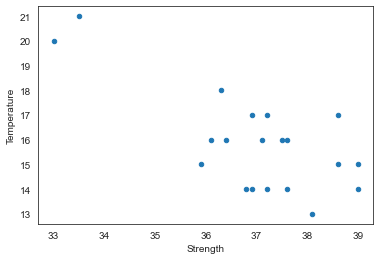

In [149]:
# 산점도를 그려서 두 변수간 상관관계를 시각화한다.
df.plot.scatter('Strength', 'Temperature')

- 산점도를 보면 두 변수 간 음의 상관관계가 나타나는 것 같다.

In [150]:
corr, pval = stats.pearsonr(df['Strength'], df['Temperature'])

print("Pearson R:")
print("상관계수: {0:.3f}, P-Value: {1:.3f}".format(corr, pval))

Pearson R:
상관계수: -0.723, P-Value: 0.000


- 예상한대로 음의 상관관계가 있으며,
- p-value가 0이므로 음의 상관관계가 통계적으로 아주 유의미하다.
- 상관계수도 -.72로 상당히 높은 수준임을 알 수 있다.

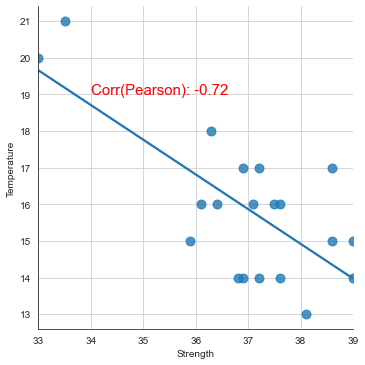

In [151]:
# correlation line을 시각화해보았다
sns.lmplot(x='Strength', y='Temperature', data=df, ci=None,
           scatter_kws={'s': 80}, size=5)
plt.grid()
plt.text(34, 19, 'Corr(Pearson): -0.72', color='r', size=15)
plt.show()

In [152]:
# 상관계수 수식을 활용해서 상관계수를 직접 계산해본다.
varr = np.var(df['Strength']) * np.var(df['Temperature'])

sum_ = 0
for x, y in zip(df['Strength'], df['Temperature']):
    sum_ += (x - np.mean(df['Strength'])) * (y - np.mean(df['Temperature']))

sum_ = sum_ / len(df)

In [155]:
print("직접 계산해서 얻은 상관계수: ", sum_ / np.sqrt(varr))

직접 계산해서 얻은 상관계수:  -0.7231073149351572


- stats.pearsonr 메서드를 사용해서 얻은 상관계수와 똑같다.

### 단순선형회귀 (p.204)
- 단순선형회귀 구하기
    - $\beta_1$의 분자는 cov(x, y); 분모는 var(x)
    - $\beta_0 = \bar y - \hat \beta_1 \bar x$

In [167]:
df = pd.read_csv('data/data2/correlation.csv')
# strength와 b_time만 사용해서 회귀분석!
df.drop(['temp', 'Quantity', 'Oven_TMP'], axis=1, inplace=True)
df.head()

,strength,b_time
0,37.6,0.798922
1,38.6,0.849020
2,37.2,0.816163
3,36.4,0.758266
4,38.6,0.815894


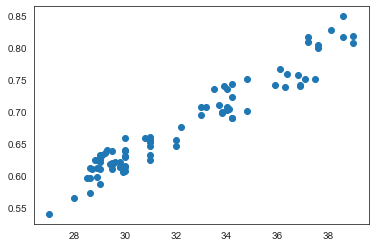

In [168]:
# strength와 b_time의 산점도
plt.scatter(df['strength'], df['b_time'])

- 산점도를 보면 강한 양의 상관관계가 보인다.

In [170]:
df.corr(method='pearson').round(3)

,strength,b_time
strength,1.000,0.966
b_time,0.966,1.000


- 상관계수가 0.966으로 두 변수 간에 매우 높은 선형관계가 있다는 걸 알 수 있다.

In [174]:
reg_model = smf.ols(formula = "strength ~ b_time", data=df)
reg_result = reg_model.fit()
reg_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1169.
Date:                Wed, 11 Aug 2021   Prob (F-statistic):           4.60e-51
Time:                        23:45:57   Log-Likelihood:                -107.75
No. Observations:                  86   AIC:                             219.5
Df Residuals:                      84   BIC:                             224.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1034      0.885      2.377      0.020       0.343       3.863
b_time        44.5520      1.303     34.186      0.000      41.960      47.144
==============================================================================
Omnibus:                        5.137   Durbin-Watson:                   1.395
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                2.908
Skew:                           0.228   Prob(JB):                        0.234
Kurtosis:                       2.223   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- p 값이 0에 가까우므로 회귀모델로서 유의하다
- R^가 0.933으로, 전체 변동의 93%를 설명할 수 있는 회귀모델이다.
- b_time의 coef는 44.5로, b_time이 1 증가할 때마다 strength가 44.5 정도 증가하는 상관관계가 있다.

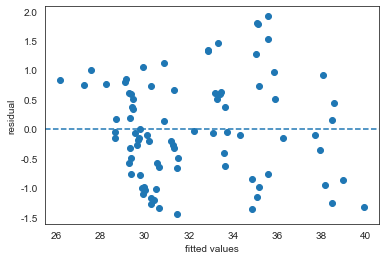

In [175]:
# 등분산성 검정
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel('fitted values')
plt.ylabel('residual')
plt.axhline(y=0, linestyle='--')

- y=0을 기준으로 분산이 크게 퍼지거나 줄어드는 경우가 없이 고르게 분포하고 있다 => 잔차의 등분산성이 확인된다.

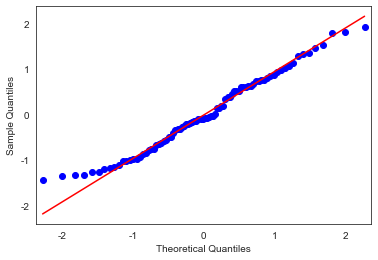

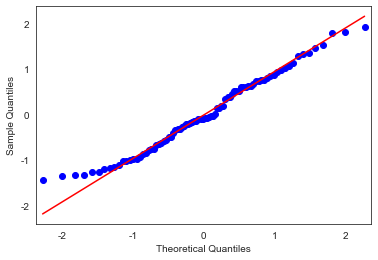

In [188]:
# 정규성 검정
sm.qqplot(reg_result.resid, line='q')

In [189]:
from statsmodels.stats.stattools import omni_normtest
omni_normtest(reg_result.resid, axis=0)

NormaltestResult(statistic=5.137339293334055, pvalue=0.07663743249973556)

- qqplot에서 잔차가 전반적으로 대각선 위에 분포하고 있으며,
- omni_normtest의 p값이 귀무가설을 채택하므로,
- 잔차가 정규성을 갖는다고 말할 수 있다.

#### 최종 회귀식
$$ \hat y = 2.1034 + 44.5520 * x $$